In [ ]:
!pip install kaggle
!pip install -q -U tensorboard
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%load_ext tensorboard

In [ ]:
# Download classification dataset
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d julian3833/jigsaw-toxic-comment-classification-challenge
!unzip -q /content/jigsaw-toxic-comment-classification-challenge.zip

 97% 52.0M/53.4M [00:00<00:00, 83.1MB/s]
100% 53.4M/53.4M [00:00<00:00, 75.4MB/s]


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
import glob

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
MAX_WORDS = 20000
MAX_LEN = 100

train = pd.read_csv('train.csv')
train_text, val_text, train_labels, val_labels = train_test_split(train['comment_text'], train.iloc[:, 2:], test_size=0.2)

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_text)
train_sequences = tokenizer.texts_to_sequences(train_text)
val_sequences = tokenizer.texts_to_sequences(val_text)

train_data = pad_sequences(train_sequences, maxlen=MAX_LEN)
val_data = pad_sequences(val_sequences, maxlen=MAX_LEN)

In [ ]:
EMBEDDING_DIM = 128
LSTM_UNITS = 64
DENSE_UNITS = 50
DROPOUT_RATE = 0.1
NUM_CLASSES = 6
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
EPOCHS = 25

def create_model():
    with strategy.scope():
        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=True)),
            tf.keras.layers.GlobalMaxPool1D(),
            tf.keras.layers.Dense(DENSE_UNITS, activation='relu'),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')
        ])

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()

In [ ]:
logs_base_dir = "logs"
os.makedirs(logs_base_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.h5',
    save_weights_only=False,
    save_freq='epoch'
)

history = model.fit(
    train_data, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS,
    validation_data=(val_data, val_labels),
    callbacks=[checkpoint_callback]
)

Epoch 1/25
125/125 [==============================] - 24s 120ms/step - loss: 0.1998 - accuracy: 0.6395 - val_loss: 0.1086 - val_accuracy: 0.8613
Epoch 2/25
125/125 [==============================] - 9s 76ms/step - loss: 0.0686 - accuracy: 0.8071 - val_loss: 0.0560 - val_accuracy: 0.9941
Epoch 3/25
125/125 [==============================] - 10s 78ms/step - loss: 0.0511 - accuracy: 0.9019 - val_loss: 0.0510 - val_accuracy: 0.9940
Epoch 4/25
125/125 [==============================] - 9s 75ms/step - loss: 0.0465 - accuracy: 0.9041 - val_loss: 0.0501 - val_accuracy: 0.9940
Epoch 5/25
125/125 [==============================] - 10s 76ms/step - loss: 0.0437 - accuracy: 0.9193 - val_loss: 0.0502 - val_accuracy: 0.9940
Epoch 6/25
125/125 [==============================] - 10s 78ms/step - loss: 0.0415 - accuracy: 0.9312 - val_loss: 0.0530 - val_accuracy: 0.9940
Epoch 7/25
125/125 [==============================] - 9s 75ms/step - loss: 0.0397 - accuracy: 0.9215 - val_loss: 0.0534 - val_accuracy: 0

In [ ]:
%tensorboard --logdir logs

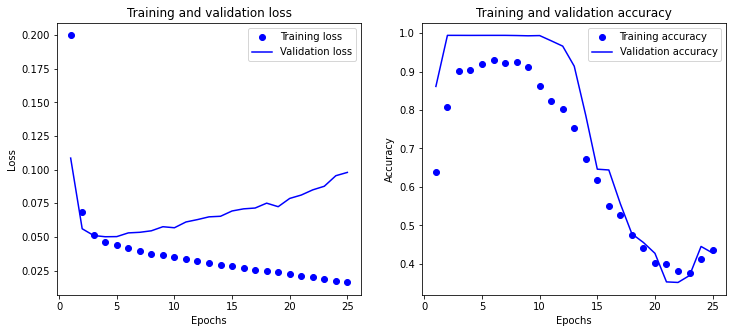

In [ ]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
def load_latest_model():
    list_of_files = glob.glob('model_epoch_*.h5')
    latest_model_file = max(list_of_files, key=os.path.getctime)
    print(f"Loading the latest model: {latest_model_file}")
    return tf.keras.models.load_model(latest_model_file)

def predict_toxicity(text, tokenizer, model=None):
    if model is None:
        model = load_latest_model()
    sequence = tokenizer.texts_to_sequences([text])
    data = pad_sequences(sequence, maxlen=MAX_LEN)
    prediction = model.predict(data)
    return prediction

threshold = 0.5
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


input_text = "suck shit, bitch"
scores = np.squeeze(predict_toxicity(input_text, tokenizer))
predicted_labels = [label for score, label in zip(scores, labels) if score > threshold]
print(predicted_labels)


Loading the latest model: model_epoch_07.h5
1/1 [==============================] - 1s 772ms/step
['toxic', 'severe_toxic', 'obscene', 'insult']


In [ ]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)